In [58]:
import os
import numpy as np
import zipfile
from ultralytics import YOLO
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [59]:
# if it is unzipped, unzip kagglecatsanddogs_5340.zip
if not os.path.exists('PetImages') and not os.path.exists('train_images'):
    # unzip kagglecatsanddogs_5340.zip
    print("The file is not unzipped, unzipping it now")
    with zipfile.ZipFile("kagglecatsanddogs_5340.zip","r") as zip_ref:
        zip_ref.extractall()
    # delete unnecessary files
    os.remove("CDLA-Permissive-2.0.pdf")
    os.remove("readme[1].txt")
else:
    print("The file is already unzipped")

The file is already unzipped


In [60]:
# rename the images as img_0.jpg, img_1.jpg, etc. and save the labels in a pandas dataframe where 0 is cat and 1 is dog
# there is ID and label in the dataframe
# the labels are 0 for cat and 1 for dog
# images folder should be in the same directory as this file

if not os.path.exists('train_images') and not os.path.exists('val_images') and not os.path.exists('test_images'):
    print("Creating images folder and labels dataframe")
    os.makedirs('train_images')
    os.makedirs('val_images')
    os.makedirs('test_images')
    train_split = 0.8
    test_split = 0.1
    val_split = 0.1
    train_labels = pd.DataFrame(columns=['ID', 'label'])
    val_labels = pd.DataFrame(columns=['ID', 'label'])
    test_labels = pd.DataFrame(columns=['ID', 'label'])
    corrupted_count = 0
    train_count = 0
    val_count = 0
    test_count = 0
    for folder in ['Cat', 'Dog']:
        for i, file in enumerate(tqdm(os.listdir('PetImages/'+folder), desc=f"Processing {folder} images")):
            # choose randomly with other_images_split percent of the images to be in the other_images folder
            if np.random.rand() < test_split:
                try:
                    img_array = cv.imread('PetImages/'+folder+'/'+file)
                    otherImage = cv.resize(img_array, (256, 256), interpolation=cv.INTER_AREA)
                    os.rename('PetImages/'+folder+'/'+file, 'test_images/img_'+str(test_count)+'.jpg')
                    test_labels.loc[test_count] = [test_count, 0 if folder == 'Cat' else 1]
                    test_count += 1
                except Exception as e:
                    corrupted_count += 1
                    os.remove('PetImages/'+folder+'/'+file)
            elif np.random.rand() < val_split:
                try:
                    img_array = cv.imread('PetImages/'+folder+'/'+file)
                    otherImage = cv.resize(img_array, (256, 256), interpolation=cv.INTER_AREA)
                    os.rename('PetImages/'+folder+'/'+file, 'val_images/img_'+str(val_count)+'.jpg')
                    val_labels.loc[val_count] = [val_count, 0 if folder == 'Cat' else 1]
                    val_count += 1
                except Exception as e:
                    corrupted_count += 1
                    os.remove('PetImages/'+folder+'/'+file)
            else:
                try:
                    img_array = cv.imread('PetImages/'+folder+'/'+file)
                    otherImage = cv.resize(img_array, (256, 256), interpolation=cv.INTER_AREA)
                    os.rename('PetImages/'+folder+'/'+file, 'train_images/img_'+str(train_count)+'.jpg')
                    train_labels.loc[train_count] = [train_count, 0 if folder == 'Cat' else 1]
                    train_count += 1
                except Exception as e:
                    corrupted_count += 1
                    os.remove('PetImages/'+folder+'/'+file)
    # delete the PetImages folder
    if os.path.exists('PetImages'):
        if os.path.exists('PetImages/Cat'):
            os.rmdir('PetImages/Cat')
        if os.path.exists('PetImages/Dog'):
            os.rmdir('PetImages/Dog')
        os.rmdir('PetImages')
    #  save the labels dataframe as a csv file
    train_labels.to_csv('train_labels.csv')
    val_labels.to_csv('val_labels.csv')
    test_labels.to_csv('test_labels.csv')
    print("Number of corrupted images: ", corrupted_count)
else:
    print("images folder already exists")

        

images folder already exists


In [61]:
#defining dataset class
class Dataset(torch.utils.data.Dataset):
      'Characterizes a dataset for PyTorch'
      def __init__(self, image_dir, label_dir, transform=None):
            'Initialization'
            self.image_dir = image_dir
            self.label_dir = label_dir
            self.transform = transform

            self.labels = pd.read_csv(label_dir)
            self.images = []
            # go through the images folder and add the names of the images to the images list with the order
            for i, file in enumerate(os.listdir(image_dir)):
                  self.images.append(f"img_{str(i)}.jpg")
            # Note: store the directory of the images instead of the images themselves


      def __len__(self):
            # return the number of samples
            return len(self.labels)

      def __getitem__(self, index):
            'Generates one sample of data'
            img_dir = self.images[index]
            img = cv.imread(self.image_dir + '/' + img_dir)
            if self.transform:
                  img = self.transform(img)
            label = self.labels.loc[self.labels['ID'] == index, 'label'].item()
            # one-hot encode the label
            label = torch.tensor([label])
            label = torch.nn.functional.one_hot(label, num_classes=2).squeeze()
            return img, label



In [62]:
# define the model
# we are using AlexNet model with 2 classes
# we are defining the model from scratch

class AlexNet(torch.nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(9216, 4096),
            nn.LeakyReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(4096, 4096),
            nn.LeakyReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1))
        
        
    def forward(self, x):
        # define the forward pass
        z = self.layer1(x)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z) 
        z = self.layer5(z)
        z = z.reshape(z.size(0), -1)
        z = self.fc(z)
        z = self.fc1(z)
        z = self.fc2(z)
        return z
        

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: NVIDIA GeForce GTX 1650 with Max-Q Design
Total GPU Memory: 4.0 GB


In [64]:
## Define hyperparameters
leanring_rate = 0.0005
epochs = 25
dropout_prob = 0.5
num_classes = 2
batch_size = 64
weight_decay = 0.0001
momentum = 0.9

In [65]:
# create the train dataset and dataloader

# define the transformation where the the image is read from the directory, resized to 256x256, normalized and converted to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

train_dataset = Dataset(image_dir='train_images', label_dir='train_labels.csv', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Dataset(image_dir='val_images', label_dir='val_labels.csv', transform=transform)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Dataset(image_dir='test_images', label_dir='test_labels.csv', transform=transform)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [66]:
## train the model

# define the model
myModel = AlexNet(num_classes=num_classes, dropout_prob=dropout_prob).to(device)

# define the loss function as multi-class cross entropy loss
loss_function = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.SGD(myModel.parameters(), lr=leanring_rate, momentum=momentum, weight_decay=weight_decay)

# define the lists to store the loss and accuracy
train_loss_list = []
train_accuracy_list = []
val_loss_list = []

# train the model
for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    # for i, (images, labels) in enumerate(train_dataloader):
    # write with tqdm to see the progress
    for i, (images, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader),  desc="Training Epoch "+str(epoch+1)+"/"+str(epochs)):
        # move the images and labels to the device
        images = images.to(device).float()
        labels = labels.to(device).float()
        # forward pass
        outputs = myModel(images).float()   
        # calculate the loss
        loss = loss_function(outputs, labels)  
        # clear the gradients
        optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update the weights
        optimizer.step()
        # calculate the train loss
        train_loss += loss.item()
        # calculate the train accuracy
        train_accuracy += (outputs == labels).float().mean()
    # calculate the validation loss
    for i, (images, labels) in enumerate(val_dataloader):
        # move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = myModel(images)
        # calculate the loss
        loss = loss_function(outputs, torch.max(labels, 1)[1])
        # calculate the validation loss
        val_loss += loss.item()
        labels = torch.argmax(labels,dim=1).float().unsqueeze(dim=0)
        outputs = torch.argmax(outputs,dim=1).float().unsqueeze(dim=0)
        val_accuracy += (outputs == labels).float().mean()
    
    # append the loss and accuracy
    train_loss_list.append(train_loss/len(train_dataloader))
    train_accuracy_list.append(train_accuracy/len(train_dataloader))
    val_loss_list.append(val_loss/len(val_dataloader))
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader):.4f}, Validation Accuracy: {val_accuracy/len(val_dataloader):.4f}, Val Loss: {val_loss/len(val_dataloader):.4f}')

torch.save(myModel.state_dict(), 'myModel.pth')

Training Epoch 1/25:   0%|          | 0/317 [00:00<?, ?it/s]c:\Users\NSagi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Training Epoch 1/25: 100%|██████████| 317/317 [03:22<00:00,  1.56it/s]


Epoch 1/25, Train Loss: 0.6545, Validation Accuracy: 0.6464, Val Loss: 0.6308


Training Epoch 2/25: 100%|██████████| 317/317 [03:08<00:00,  1.68it/s]


Epoch 2/25, Train Loss: 0.5832, Validation Accuracy: 0.7527, Val Loss: 0.5481


Training Epoch 3/25: 100%|██████████| 317/317 [03:07<00:00,  1.69it/s]


Epoch 3/25, Train Loss: 0.5249, Validation Accuracy: 0.7906, Val Loss: 0.5131


Training Epoch 4/25: 100%|██████████| 317/317 [03:07<00:00,  1.69it/s]


Epoch 4/25, Train Loss: 0.4953, Validation Accuracy: 0.8116, Val Loss: 0.4925


Training Epoch 5/25: 100%|██████████| 317/317 [03:07<00:00,  1.70it/s]


Epoch 5/25, Train Loss: 0.4749, Validation Accuracy: 0.8246, Val Loss: 0.4759


Training Epoch 6/25: 100%|██████████| 317/317 [03:07<00:00,  1.69it/s]


Epoch 6/25, Train Loss: 0.4641, Validation Accuracy: 0.8170, Val Loss: 0.4858


Training Epoch 7/25: 100%|██████████| 317/317 [03:06<00:00,  1.70it/s]


Epoch 7/25, Train Loss: 0.4511, Validation Accuracy: 0.8496, Val Loss: 0.4557


Training Epoch 8/25: 100%|██████████| 317/317 [03:06<00:00,  1.70it/s]


Epoch 8/25, Train Loss: 0.4411, Validation Accuracy: 0.8335, Val Loss: 0.4692


Training Epoch 9/25: 100%|██████████| 317/317 [03:07<00:00,  1.70it/s]


Epoch 9/25, Train Loss: 0.4309, Validation Accuracy: 0.8527, Val Loss: 0.4525


Training Epoch 10/25: 100%|██████████| 317/317 [03:07<00:00,  1.69it/s]


Epoch 10/25, Train Loss: 0.4234, Validation Accuracy: 0.8661, Val Loss: 0.4440


Training Epoch 11/25: 100%|██████████| 317/317 [03:09<00:00,  1.67it/s]


Epoch 11/25, Train Loss: 0.4182, Validation Accuracy: 0.8629, Val Loss: 0.4426


Training Epoch 12/25: 100%|██████████| 317/317 [03:18<00:00,  1.59it/s]


Epoch 12/25, Train Loss: 0.4127, Validation Accuracy: 0.8540, Val Loss: 0.4482


Training Epoch 13/25: 100%|██████████| 317/317 [02:52<00:00,  1.83it/s]


Epoch 13/25, Train Loss: 0.4047, Validation Accuracy: 0.8580, Val Loss: 0.4463


Training Epoch 14/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 14/25, Train Loss: 0.4021, Validation Accuracy: 0.8647, Val Loss: 0.4377


Training Epoch 15/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 15/25, Train Loss: 0.3946, Validation Accuracy: 0.8804, Val Loss: 0.4274


Training Epoch 16/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 16/25, Train Loss: 0.3903, Validation Accuracy: 0.8813, Val Loss: 0.4270


Training Epoch 17/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 17/25, Train Loss: 0.3845, Validation Accuracy: 0.8795, Val Loss: 0.4282


Training Epoch 18/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 18/25, Train Loss: 0.3825, Validation Accuracy: 0.8888, Val Loss: 0.4159


Training Epoch 19/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 19/25, Train Loss: 0.3793, Validation Accuracy: 0.8871, Val Loss: 0.4209


Training Epoch 20/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 20/25, Train Loss: 0.3750, Validation Accuracy: 0.8844, Val Loss: 0.4235


Training Epoch 21/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 21/25, Train Loss: 0.3713, Validation Accuracy: 0.8902, Val Loss: 0.4172


Training Epoch 22/25: 100%|██████████| 317/317 [02:54<00:00,  1.82it/s]


Epoch 22/25, Train Loss: 0.3668, Validation Accuracy: 0.8875, Val Loss: 0.4208


Training Epoch 23/25: 100%|██████████| 317/317 [02:53<00:00,  1.83it/s]


Epoch 23/25, Train Loss: 0.3665, Validation Accuracy: 0.8973, Val Loss: 0.4059


Training Epoch 24/25: 100%|██████████| 317/317 [02:54<00:00,  1.82it/s]


Epoch 24/25, Train Loss: 0.3625, Validation Accuracy: 0.8808, Val Loss: 0.4255


Training Epoch 25/25: 100%|██████████| 317/317 [03:03<00:00,  1.73it/s]


Epoch 25/25, Train Loss: 0.3599, Validation Accuracy: 0.8920, Val Loss: 0.4170


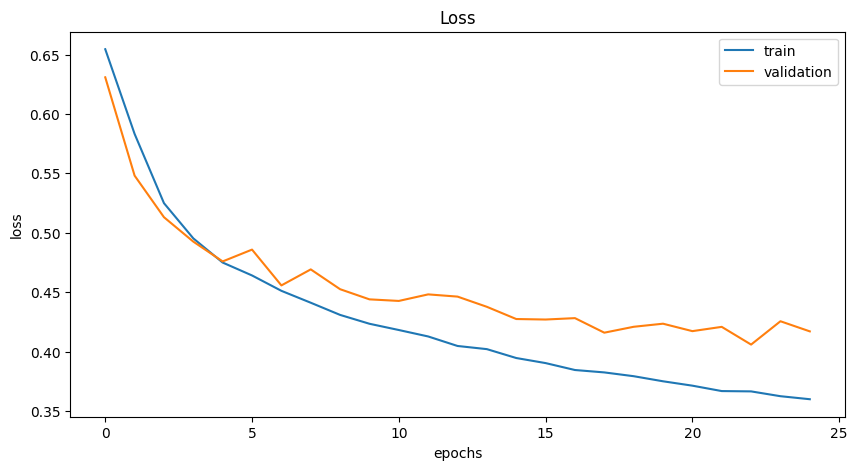

In [67]:
# plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.title("Loss")
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [68]:
# test the model with the test dataset

# define the lists to store the loss and accuracy
test_loss_list = []
test_accuracy_list = []
total = 0

# test the model

test_loss = 0
test_accuracy = 0
# for i, (images, labels) in enumerate(train_dataloader):
# write with tqdm to see the progress
for i, (images, labels) in tqdm(enumerate(test_dataloader), total=len(test_dataloader),  desc="Testing"):
    # move the images and labels to the device
    images = images.to(device).float()
    labels = labels.to(device).float()
    # forward pass
    outputs = myModel(images).float()   
    # calculate the loss
    loss = loss_function(outputs, labels)  
    # calculate the test loss
    test_loss += loss.item()
    # calculate the test accuracy
    # de one hot encode the labels and outputs
    labels = torch.argmax(labels,dim=1).float().unsqueeze(dim=0)
    outputs = torch.argmax(outputs,dim=1).float().unsqueeze(dim=0)
    test_accuracy += (outputs == labels).float().mean()
    total += 1
# append the loss and accuracy
test_loss_list.append(test_loss/len(test_dataloader))
test_accuracy_list.append(test_accuracy/len(test_dataloader))
print(f'Test Loss: {test_loss/len(test_dataloader):.4f}, \
    Test Accuracy: {test_accuracy/len(test_dataloader):.4f}')



Testing:   0%|          | 0/39 [00:00<?, ?it/s]

Testing: 100%|██████████| 39/39 [00:19<00:00,  2.02it/s]

Test Loss: 0.4116,     Test Accuracy: 0.8983


Prediction:  Dog


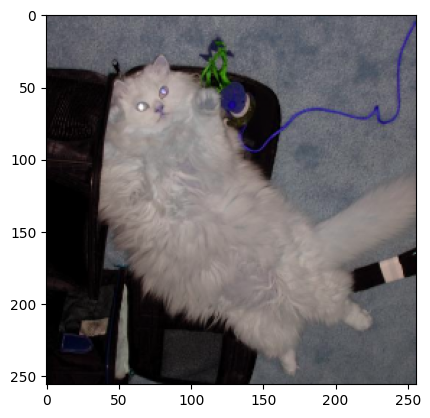

tensor([[0.0260, 0.9740]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
0.9740369915962219


In [88]:

# print a random image from the other_images folder and show the prediction
random_index = np.random.randint(0, 2536)
image, label = test_dataset[random_index]
image = image.to(device)
label = label.to(device)
output = myModel(image.unsqueeze(0))
print("Prediction: ", "Cat" if output.argmax(dim=1) == 0 else "Dog")
plt.imshow(image.permute(1,2,0).cpu())
plt.show()

print(output)
print(f"{torch.max(output)}")


In [70]:
# calculate the loss between two one hot encoded vectors
# define 2d vectors
vector1 = torch.tensor([[0.54, 0.32], [1, 0]]).float()
vector2 = torch.tensor([[0.43, 0.75], [1, 0]]).float()
# de-one-hot encode the vectors
vector1 = torch.argmax(vector1,dim=1).float().unsqueeze(dim=0)
vector2 = torch.argmax(vector2, dim=1).float().unsqueeze(dim=0)
print(f"vector1 is {vector1}")
print(f"vector2 is {vector2}")
loss_function = nn.CrossEntropyLoss()
loss = loss_function(vector1, vector2)
print(f"loss is {loss}")

vector1 is tensor([[0., 0.]])
vector2 is tensor([[1., 0.]])
loss is 0.6931471824645996


Prediction:  Cat


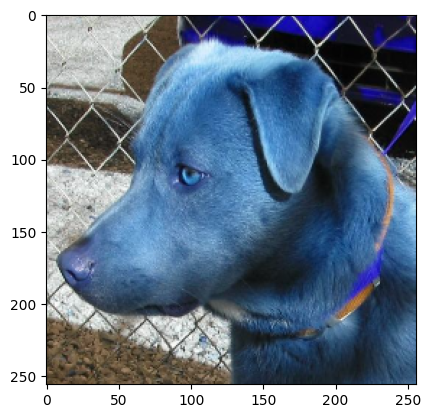

tensor([[0.9987, 0.0013]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
0.9987097978591919


In [109]:
# load the model to myModel2
myModel2 = AlexNet(num_classes=num_classes, dropout_prob=0.1).to(device)
myModel2.load_state_dict(torch.load('myModel.pth'))

# print a random image from the other_images folder and show the prediction
random_index = np.random.randint(0, 2482)
image, label = test_dataset[random_index]
image = image.to(device)
label = label.to(device)
output = myModel2(image.unsqueeze(0))
print("Prediction: ", "Cat" if output.argmax(dim=1) == 0 else "Dog")
plt.imshow(image.permute(1,2,0).cpu())
plt.show()

print(output)
print(f"{torch.max(output)}")
